<a href="https://colab.research.google.com/github/megasiska86/Neural-Network-Repository/blob/master/googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
!unzip fashion-mnist-master.zip

Archive:  fashion-mnist-master.zip
629abc0f9a73c2897383a9178e8e38f7141be30d
  inflating: fashion-mnist-master/.catwatch.yaml  
 extracting: fashion-mnist-master/.dockerignore  
  inflating: fashion-mnist-master/.gitignore  
  inflating: fashion-mnist-master/.zappr.yaml  
  inflating: fashion-mnist-master/CONTRIBUTING.md  
  inflating: fashion-mnist-master/Dockerfile  
  inflating: fashion-mnist-master/LICENSE  
  inflating: fashion-mnist-master/MAINTAINERS  
  inflating: fashion-mnist-master/README.ja.md  
  inflating: fashion-mnist-master/README.md  
  inflating: fashion-mnist-master/README.zh-CN.md  
  inflating: fashion-mnist-master/app.py  
   creating: fashion-mnist-master/benchmark/
 extracting: fashion-mnist-master/benchmark/__init__.py  
  inflating: fashion-mnist-master/benchmark/baselines.json  
  inflating: fashion-mnist-master/benchmark/convnet.py  
  inflating: fashion-mnist-master/benchmark/runner.py  
  inflating: fashion-mnist-master/configs.py  
   creating: fashion-mn

In [0]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.Grayscale(num_output_channels=3),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = torchvision.datasets.FashionMNIST(root='fashion-mnist-master', train=True, transform=transform,
                                        download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.FashionMNIST(root='fashion-mnist-master', train=False, transform=transform,
                                       download=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=0)
trainset1,validset = torch.utils.data.random_split(trainset, [50000,10000])
trainloader1=torch.utils.data.DataLoader(trainset1, batch_size=8,shuffle=True, num_workers=0)
validloader=torch.utils.data.DataLoader(validset, batch_size=8,shuffle=True, num_workers=0)

classes = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [0]:
torch.save({'trainset1': trainset1, 'validset': validset,'trainloader1': trainloader1, 'validloader': validloader,'testset': testset, 'testloader':testloader}, 'datasetg.pth')

In [0]:
!cp '/content/datasetg.pth' '/content/drive/My Drive/Colab Notebooks/datasetg.pth'

In [0]:
checkpoint = torch.load('datasetg.pth')
trainset1 = checkpoint['trainset1']
validset = checkpoint['validset']
trainloader1 = checkpoint['trainloader1']
validloader =checkpoint['validloader']
testset = checkpoint['testset']
testloader =checkpoint['testloader']

In [0]:
import warnings
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.model_zoo import load_url as load_state_dict_from_url

__all__ = ['GoogLeNet', 'googlenet']

model_urls = {
    # GoogLeNet ported from TensorFlow
    'googlenet': 'https://download.pytorch.org/models/googlenet-1378be20.pth',
}

_GoogLeNetOutputs = namedtuple('GoogLeNetOutputs', ['logits', 'aux_logits2', 'aux_logits1'])


def googlenet(pretrained=False, progress=True, **kwargs):
    r"""GoogLeNet (Inception v1) model architecture from
    `"Going Deeper with Convolutions" <http://arxiv.org/abs/1409.4842>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        aux_logits (bool): If True, adds two auxiliary branches that can improve training.
            Default: *False* when pretrained is True otherwise *True*
        transform_input (bool): If True, preprocesses the input according to the method with which it
            was trained on ImageNet. Default: *False*
    """
    if pretrained:
        if 'transform_input' not in kwargs:
            kwargs['transform_input'] = True
        if 'aux_logits' not in kwargs:
            kwargs['aux_logits'] = False
        if kwargs['aux_logits']:
            warnings.warn('auxiliary heads in the pretrained googlenet model are NOT pretrained, '
                          'so make sure to train them')
        original_aux_logits = kwargs['aux_logits']
        kwargs['aux_logits'] = True
        kwargs['init_weights'] = False
        model = GoogLeNet(**kwargs)
        state_dict = load_state_dict_from_url(model_urls['googlenet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
        if not original_aux_logits:
            model.aux_logits = False
            del model.aux1, model.aux2
        return model

    return GoogLeNet(**kwargs)


class GoogLeNet(nn.Module):

    def __init__(self, num_classes=10, aux_logits=True, transform_input=False, init_weights=True):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits
        self.transform_input = transform_input

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1024, num_classes)

        if init_weights:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                import scipy.stats as stats
                X = stats.truncnorm(-2, 2, scale=0.01)
                values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                values = values.view(m.weight.size())
                with torch.no_grad():
                    m.weight.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)

        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        if self.training and self.aux_logits:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        if self.training and self.aux_logits:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = x.view(x.size(0), -1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        if self.training and self.aux_logits:
            return _GoogLeNetOutputs(x, aux2, aux1)
        return x


class Inception(nn.Module):

    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=3, padding=1)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = F.adaptive_avg_pool2d(x, (4, 4))
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = x.view(x.size(0), -1)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        # N x 2048
        x = F.dropout(x, 0.7, training=self.training)
        # N x 2048
        x = self.fc2(x)
        # N x 1024

        return x


class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)
model=GoogLeNet().to(device)

In [0]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [0]:
model=models.googlenet(pretrained=True)
model.fc=nn.Linear(1024,10)
model=model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth
100%|██████████| 52147035/52147035 [00:02<00:00, 18945897.64it/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

#smaller learning rate

In [0]:
optimizer2=optim.SGD(model.parameters(), lr=0.0001)
#optimizer1 = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn2 = nn.CrossEntropyLoss()
scheduler2 = lr_scheduler.CyclicLR(optimizer1, base_lr=0.0001, max_lr=0.0006, step_size_up=18000)

In [0]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
train_acc_list=[]
test_acc_list=[]
start_epoch=0
e=5

In [0]:
for epoch in range(start_epoch,40):
    #exp_lr_scheduler.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 1600) % (1600 * 1600) == 0:
            print(i*10, '/ 50000')
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
                
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses.append(m_t_l)
    mean_valid_losses.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list.append(accuracy_v)
    train_acc_list.append(accuracy_t)
    
    
        #save
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(), 'train loss': mean_train_losses,'train acc': train_acc_list, 'valid loss':mean_valid_losses, 'valid acc': valid_acc_list}, 'google.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f}% valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list),np.min(mean_train_losses)))
b_val_acc=np.max(valid_acc_list)
b_val_loss=np.min(mean_valid_losses)
b_train_acc=np.max(train_acc_list)
b_train_loss=np.min(mean_train_losses)
torch.save({'best val acc':b_val_acc,'best val loss':b_val_loss,'best train acc':b_train_acc,'best train loss':b_train_loss},'bestg.pth')

0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000
64000 / 50000
epoch : 31, train loss : 0.0799, train acc : 97.19% valid loss : 0.3035, valid acc : 91.74%
0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000
64000 / 50000
epoch : 32, train loss : 0.0733, train acc : 97.37% valid loss : 0.2965, valid acc : 91.82%
0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000
64000 / 50000
epoch : 33, train loss : 0.0725, train acc : 97.40% valid loss : 0.3018, valid acc : 92.32%
0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000
64000 / 50000
epoch : 34, train loss : 0.0692, train acc : 97.56% valid loss : 0.3432, valid acc : 91.57%
0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000
64000 / 50000
epoch : 35, train loss : 0.0674, train acc : 97.55% valid loss : 0.3013, valid acc : 91.87%
0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000
64000 / 50000
epoch : 36, train loss : 0.0663, train acc : 97.60% valid loss : 0.2926, valid acc : 92.25%
0 / 50000
16000 / 50000
32000 / 50000
48000 / 50000


In [0]:
checkpoint = torch.load('google.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
mean_train_losses = checkpoint['train loss']
train_acc_list=checkpoint['train acc']
mean_valid_losses = checkpoint['valid loss']
valid_acc_list=checkpoint['valid acc']

In [0]:
checkpoint = torch.load('bestg.pth')
b_val_acc=checkpoint['best val acc']
b_val_loss=checkpoint['best val loss']
b_train_acc=checkpoint['best train acc']
b_train_loss=checkpoint['best train loss']

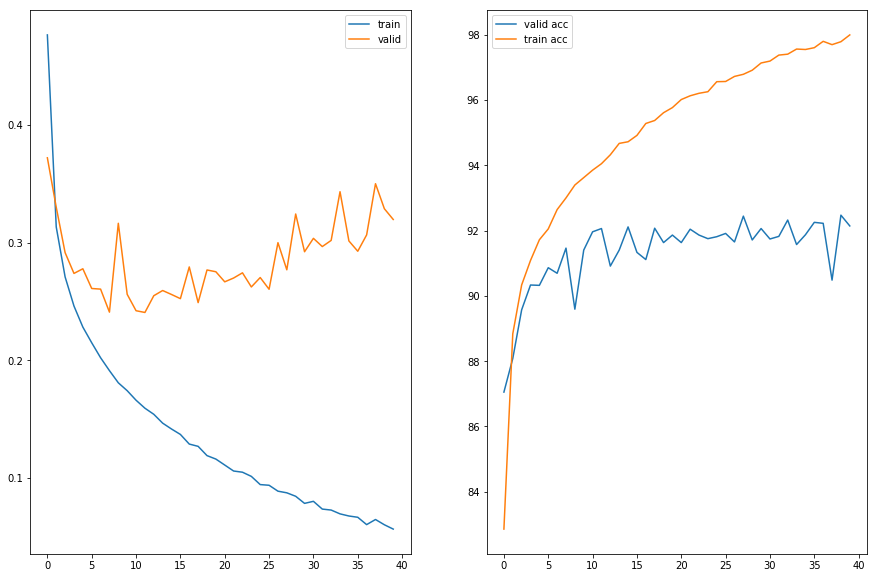

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses, label='train')
ax1.plot(mean_valid_losses, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(valid_acc_list, label='valid acc')
ax2.plot(train_acc_list, label='train acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

In [0]:
correct_te = 0
total_te = 0
with torch.no_grad():
    for i, data in enumerate(testloader):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        outputs = model(images)
        _, predicted_v = torch.max(outputs.data, 1)
        correct_te += (predicted_v == labels).sum().item()
        total_te += labels.size(0)
accuracy_te = 100*correct_te/total_te
print(accuracy_te)

92.15


In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp '/content/bestg.pth' '/content/drive/My Drive/Colab Notebooks/bestg.pth'

In [0]:
!cp '/content/bestg2.pth' '/content/drive/My Drive/Colab Notebooks/bestg2.pth'

In [0]:
!cp '/content/bestg3.pth' '/content/drive/My Drive/Colab Notebooks/bestg3.pth'

In [0]:
!cp '/content/bestg4.pth' '/content/drive/My Drive/Colab Notebooks/bestg4.pth'

In [0]:
!cp '/content/google.pth' '/content/drive/My Drive/Colab Notebooks/google.pth'

In [0]:
!cp '/content/google2.pth' '/content/drive/My Drive/Colab Notebooks/google2.pth'

In [0]:
!cp '/content/google3.pth' '/content/drive/My Drive/Colab Notebooks/google3.pth'

In [0]:
!cp '/content/google4.pth' '/content/drive/My Drive/Colab Notebooks/google4.pth'

#scheduler

In [0]:
optimizer2=optim.SGD(model.parameters(), lr=0.001)
#optimizer1 = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn2 = nn.CrossEntropyLoss()
#scheduler2 = lr_scheduler.CyclicLR(optimizer2, base_lr=0.001, max_lr=0.006, step_size_up=18750)
#scheduler2 = lr_scheduler.CyclicLR(optimizer2, base_lr=0.002, max_lr=0.006, step_size_up=12500)
scheduler2 = lr_scheduler.CyclicLR(optimizer2, base_lr=0.0015, max_lr=0.006, step_size_up=15625)

In [0]:
mean_train_losses2 = []
mean_valid_losses2 = []
valid_acc_list2 = []
train_acc_list2=[]
test_acc_list2=[]
start_epoch2=0
e2=5

In [0]:
for epoch in range(start_epoch2,15):
    scheduler2.step()
    model.train()
    
    train_losses = []
    valid_losses = []
    model.eval()
    correct_t = 0
    total_t = 0
    for i, data in enumerate(trainloader1):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        
        optimizer2.zero_grad()
        
        outputs = model(images)
        loss = loss_fn2(outputs, labels)
        loss.backward()
        optimizer2.step()
        
        train_losses.append(loss.item())
        
        _, predicted_t = torch.max(outputs.data, 1)
        correct_t += (predicted_t == labels).sum().item()
        total_t += labels.size(0)
        
        if (i * 2100) % (2100 * 2100) == 0:
            print(i*10, '/ 50000')
            
    model.eval()
    correct_v = 0
    total_v = 0
    with torch.no_grad():
        for i, data in enumerate(validloader):
            images,labels=data
            images,labels=images.to(device),labels.to(device)
            outputs = model(images)
            loss = loss_fn2(outputs, labels)
            
            valid_losses.append(loss.item())
            
            _, predicted_v = torch.max(outputs.data, 1)
            correct_v += (predicted_v == labels).sum().item()
            total_v += labels.size(0)
                
    m_t_l=np.mean(train_losses)
    m_v_l=np.mean(valid_losses)
            
    mean_train_losses2.append(m_t_l)
    mean_valid_losses2.append(m_v_l)
    
    accuracy_v = 100*correct_v/total_v
    accuracy_t = 100*correct_t/total_t
    valid_acc_list2.append(accuracy_v)
    train_acc_list2.append(accuracy_t)
    
    
        #save
    #torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer2.state_dict(), 'train loss': mean_train_losses2,'train acc': train_acc_list2, 'valid loss':mean_valid_losses2, 'valid acc': valid_acc_list2}, 'google2.pth')
    #torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer2.state_dict(), 'train loss': mean_train_losses2,'train acc': train_acc_list2, 'valid loss':mean_valid_losses2, 'valid acc': valid_acc_list2}, 'google3.pth')
    torch.save({'epoch': epoch+1, 'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer2.state_dict(), 'train loss': mean_train_losses2,'train acc': train_acc_list2, 'valid loss':mean_valid_losses2, 'valid acc': valid_acc_list2}, 'google4.pth')
    print('epoch : {}, train loss : {:.4f}, train acc : {:.2f}% valid loss : {:.4f}, valid acc : {:.2f}%'.format(epoch+1, m_t_l, accuracy_t, m_v_l, accuracy_v))
b_val_acc2=np.max(valid_acc_list2)
b_val_loss2=np.min(mean_valid_losses2)
b_train_acc2=np.max(train_acc_list2)
b_train_loss2=np.min(mean_train_losses2)
#torch.save({'best val acc':b_val_acc2,'best val loss':b_val_loss2,'best train acc':b_train_acc2,'best train loss':b_train_loss2},'bestg2.pth')
#torch.save({'best val acc':b_val_acc2,'best val loss':b_val_loss2,'best train acc':b_train_acc2,'best train loss':b_train_loss2},'bestg3.pth')
torch.save({'best val acc':b_val_acc2,'best val loss':b_val_loss2,'best train acc':b_train_acc2,'best train loss':b_train_loss2},'bestg4.pth')
print('best val acc: {0}, best train loss: {1}'.format(np.max(valid_acc_list2),np.min(mean_train_losses2)))

0 / 50000
21000 / 50000
42000 / 50000
epoch : 11, train loss : 0.0446, train acc : 98.45% valid loss : 0.2141, valid acc : 94.25%
0 / 50000
21000 / 50000
42000 / 50000
epoch : 12, train loss : 0.0449, train acc : 98.44% valid loss : 0.1661, valid acc : 95.24%
0 / 50000
21000 / 50000
42000 / 50000
epoch : 13, train loss : 0.0381, train acc : 98.71% valid loss : 0.1837, valid acc : 94.92%
0 / 50000
21000 / 50000
42000 / 50000
epoch : 14, train loss : 0.0403, train acc : 98.57% valid loss : 0.1886, valid acc : 94.70%
0 / 50000
21000 / 50000
42000 / 50000
epoch : 15, train loss : 0.0384, train acc : 98.67% valid loss : 0.1661, valid acc : 94.81%
best val acc: 95.61, best train loss: 0.0381189013671875


In [0]:
#checkpoint = torch.load('google2.pth')
#checkpoint = torch.load('google3.pth')
checkpoint = torch.load('google4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch2 = checkpoint['epoch']
mean_train_losses2 = checkpoint['train loss']
train_acc_list2=checkpoint['train acc']
mean_valid_losses2 = checkpoint['valid loss']
valid_acc_list2=checkpoint['valid acc']

In [0]:
train_acc_list2 #google2

[98.084,
 98.158,
 98.29,
 98.276,
 98.536,
 98.374,
 98.396,
 98.556,
 98.692,
 98.628,
 98.704,
 98.698,
 98.82,
 98.702,
 98.87,
 98.908,
 98.936,
 98.852,
 98.836,
 99.008]

In [0]:
valid_acc_list2 #google2

[98.16,
 98.07,
 96.87,
 97.8,
 97.16,
 97.88,
 97.03,
 97.42,
 97.12,
 97.14,
 97.26,
 96.76,
 96.77,
 96.81,
 96.72,
 96.39,
 96.81,
 96.29,
 96.14,
 95.96]

In [0]:
#checkpoint = torch.load('bestg2.pth')
#checkpoint = torch.load('bestg3.pth')
checkpoint = torch.load('bestg4.pth')
b_val_acc2=checkpoint['best val acc']
b_val_loss2=checkpoint['best val loss']
b_train_acc2=checkpoint['best train acc']
b_train_loss2=checkpoint['best train loss']

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(mean_train_losses2, label='train loss')
ax1.plot(mean_valid_losses2, label='valid loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')
ax2.plot(train_acc_list2, label='train acc')
ax2.plot(valid_acc_list2, label='valid acc')
lines, labels = ax2.get_legend_handles_labels()
ax2.legend(lines, labels, loc='best')

In [0]:
correct_te = 0
total_te = 0
with torch.no_grad():
    for i, data in enumerate(testloader):
        images,labels=data
        images,labels=images.to(device),labels.to(device)
        outputs = model(images)
        _, predicted_v = torch.max(outputs.data, 1)
        correct_te += (predicted_v == labels).sum().item()
        total_te += labels.size(0)
accuracy_te = 100*correct_te/total_te
print(accuracy_te)

91.93
